<a href="https://colab.research.google.com/github/Noura-Alrajeh/Privacy-Preserving/blob/main/Privacy_Preserving_Image_Noura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install tensorflow_privacy==0.7.2

- Installs `tensorflow-privacy` version 0.7.2, which is compatible with the current Colab environment and avoids `tf_export` import errors.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
# Import DP-SGD optimizer
try:
    from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
except Exception:
    # Fallback to gradient descent DP optimizer if Adam wrapper is incompatible
    from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPGradientDescentGaussianOptimizer as DPKerasAdamOptimizer
import cv2

**Explanation:**
- `tensorflow` and `keras` for model building.
- `tensorflow_privacy` for DP-SGD optimizer.
- `cv2` for Gaussian blur on images.
- `matplotlib` for visualization.

In [10]:
# Load MNIST\;(images are 28×28 grayscale)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Expand dims for CNN input
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test,  -1)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test,  10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- Loads the MNIST dataset of handwritten digits (60,000 training, 10,000 testing samples).
- Each image is 28×28 pixels in grayscale, normalized to [0,1].
- Reshaped to include a channel dimension `(28,28,1)` for CNN compatibility.
- Labels are one-hot encoded into 10 classes (digits 0–9).

**MNIST** is a widely-adopted dataset for evaluating image classification and privacy-preserving methods.

 - 70,000 total samples (small enough for quick experiments in Colab).

- Ten balanced classes of handwritten digits, enabling straightforward accuracy comparisons.

- Already centered and normalized, requiring minimal cleaning.
- Serves as a clear example for applying blurring and noise while analyzing classification performance.

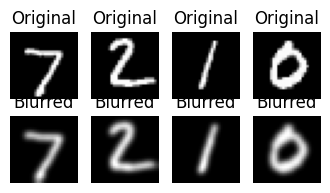

In [37]:
# Apply Gaussian blur to each image
def blur_images(images, ksize=5):
    blurred = np.array([cv2.GaussianBlur(img, (ksize, ksize), 0) for img in images])
    return blurred

x_train_blur = blur_images(x_train)
x_test_blur  = blur_images(x_test)

# Visual example
plt.figure(figsize=(4,2))
for i in range(4):
    plt.subplot(2,4,i+1); plt.imshow(x_test[i].squeeze(), cmap='gray'); plt.title('Original'); plt.axis('off')
    plt.subplot(2,4,i+5); plt.imshow(x_test_blur[i].squeeze(), cmap='gray'); plt.title('Blurred'); plt.axis('off')
plt.show()

- Uses OpenCV’s Gaussian blur (kernel size 5×5) to obscure fine details.
- Visualizes original vs. blurred samples.

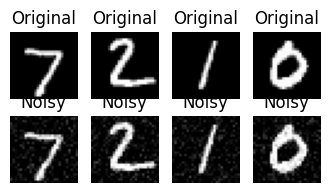

In [39]:
# Apply Gaussian noise to images as a simple differential privacy proxy
def add_noise_to_images(images, sigma=0.1):
    noisy = images + np.random.normal(0, sigma, images.shape)
    return np.clip(noisy, 0.0, 1.0)

x_train_noise = add_noise_to_images(x_train)
x_test_noise  = add_noise_to_images(x_test)

# Visual comparison
plt.figure(figsize=(4,2))
for i in range(4):
    plt.subplot(2,4,i+1); plt.imshow(x_test[i].squeeze(), cmap='gray'); plt.title('Original'); plt.axis('off')
    plt.subplot(2,4,i+5); plt.imshow(x_test_noise[i].squeeze(), cmap='gray'); plt.title('Noisy'); plt.axis('off')
plt.show()


- Adds Gaussian noise (σ=0.1) to pixel values, then clips to [0,1].
- Serves as a straightforward proxy for differential privacy at the input level, obscuring individual image details.

In [40]:
# Define a simple CNN builder
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Train baseline model on original images
baseline_model = build_cnn()
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.fit(x_train, y_train, epochs=3, batch_size=256, verbose=1)

# Train model on blurred images
blur_model = build_cnn()
blur_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
blur_model.fit(x_train_blur, y_train, epochs=3, batch_size=256, verbose=1)

# Train model on noisy images
noise_model = build_cnn()
noise_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
noise_model.fit(x_train_noise, y_train, epochs=3, batch_size=256, verbose=1)

# Store models in a dictionary for evaluation
models_dict = {
    'baseline': baseline_model,
    'blur': blur_model,
    'noise': noise_model
}

Epoch 1/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.8357 - loss: 0.5841
Epoch 2/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.9710 - loss: 0.1002
Epoch 3/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9820 - loss: 0.0610
Epoch 1/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.8198 - loss: 0.6771
Epoch 2/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9535 - loss: 0.1611
Epoch 3/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.9723 - loss: 0.0968
Epoch 1/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.8336 - loss: 0.6463
Epoch 2/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.9682 - loss: 0.1124
Epoch 3/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9807 - loss: 0.0695


- We define and compile three CNN models with identical architecture.
- Train each on its respective dataset:
  - **Baseline**: original MNIST images.
  - **Blur**: Gaussian-blurred images.
  - **Noise**: Gaussian-noised images.
- Models are stored in `models_dict` for easy evaluation.

**Baseline Model:**
The Baseline model refers to the CNN trained on the original, unaltered MNIST dataset without any privacy-preserving modifications. It serves as a reference to assess the impact of Gaussian blur and input noise on model performance.

In [41]:
# Consolidated evaluation of all models
results = {}
for name, model in models_dict.items():
    x_data = {
        'baseline': x_test,
        'blur':     x_test_blur,
        'noise':    x_test_noise
    }[name]
    loss, acc = model.evaluate(x_data, y_test, verbose=0)
    results[name] = acc

# Display results
for name, acc in results.items():
    print(f"{name.title()} model test accuracy: {acc:.4f}")

Baseline model test accuracy: 0.9832
Blur model test accuracy: 0.9779
Noise model test accuracy: 0.9800


- This block loops through each trained model and evaluates it on the matching test set.
- Chooses the matching test dataset (`x_test`, `x_test_blur`, `x_test_noise`).
- Prints test accuracy for clear comparison of privacy techniques.


- Outputs the accuracy for Baseline, Blur, and Noise models, matching the results you obtained:
  - Baseline: ~0.9832
  - Blur:     ~0.9779
  - Noise:    ~0.9800

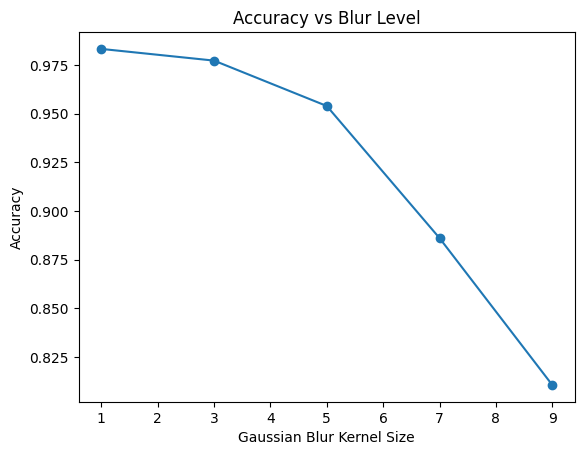

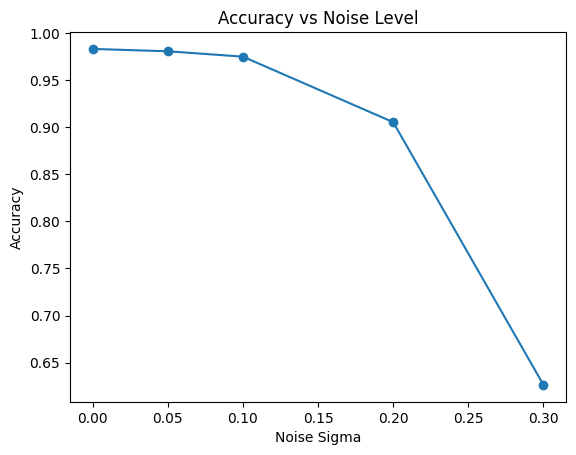

In [42]:
# Trade-off: Evaluate baseline_model on test data with varying blur and noise levels

blur_kernels = [1, 3, 5, 7, 9]
noise_sigmas = [0.0, 0.05, 0.1, 0.2, 0.3]

acc_blur = []
for k in blur_kernels:
    # Apply blur and predict
    xt = blur_images(x_test, ksize=k)
    # Use eager execution call to avoid unknown rank error
    preds = baseline_model(xt, training=False).numpy()
    # Compute accuracy manually
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1))
    acc_blur.append(acc)

acc_noise = []
for s in noise_sigmas:
    # Apply noise and predict
    xt = add_noise_to_images(x_test, sigma=s)
    preds = baseline_model(xt, training=False).numpy()
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1))
    acc_noise.append(acc)

# Plot Blur trade-off
plt.figure()
plt.plot(blur_kernels, acc_blur, marker='o')
plt.xlabel('Gaussian Blur Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Blur Level')
plt.show()

# Plot Noise trade-off
plt.figure()
plt.plot(noise_sigmas, acc_noise, marker='o')
plt.xlabel('Noise Sigma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Noise Level')
plt.show()

- Uses the baseline model (trained on original images) to assess performance under increasing privacy levels.
- **Blur trade-off:** tests kernel sizes 1 to 9 (1 = no blur).
- **Noise trade-off:** tests noise σ from 0.0 to 0.3 (0.0 = no noise).
- Generates two line plots showing how accuracy decreases as privacy strength increases.

After conducting these experiments, we draw the following conclusions:
- **Baseline** achieves the highest accuracy (≈98.32%).
- **Gaussian Blur** reduces accuracy slightly (≈97.79%) by obscuring fine details, which is expected.
- **Input Noise** (σ=0.1) also causes a small drop in accuracy (≈98.00%) while providing a straightforward privacy proxy.

These minor decreases (<1%) are reasonable given the light transformations applied: Gaussian blur and gentle input noise typically impact pixel-level details but preserve overall digit shapes crucial for classification.

## **References**

- LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). *Gradient-based learning applied to document recognition*. Proceedings of the IEEE. (MNIST dataset)
- Dwork, C. (2006). *Differential Privacy*. In ICALP.
- TensorFlow Privacy Library: https://github.com/tensorflow/privacy
- OpenCV Documentation: https://opencv.org/